In [46]:
# Imports
import pandas as pd
import numpy as np
import sys
import importlib

from skpp import ProjectionPursuitRegressor

sys.path.append("../shapley")
import shapley
importlib.reload(shapley)

# plotting
import matplotlib.pyplot as pl

# plotting
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np

# Code for parsing auROC files and running Shapley analysis

This notebook loads in auROC values produced from ../tfti/save_auc_shapley.py and runs a Shapley analysis.


## Load in text files

In [2]:
################## User Configures ##################

# location of auROC values for mark sets
auc_text_filename = '/home/eecs/akmorrow/tfti/tfti/shapley_values_64_25_gm12878_depth_5_19.txt'

In [41]:
auc_values = pd.read_csv(auc_text_filename, sep='\t')

In [42]:
mark_sets = auc_values['permutation']

def split_marks(mark_str):
    """ Splits marks in test file to list of names
    :param mark_str string of marks, of format "['ATF2', 'CEBPB']"
    """
    for ch in ["'",'[',']'," "]:
        mark_str=mark_str.replace(ch,"")
        
    if (len(mark_str) == 0):
        return []
    return mark_str.split(',')

def R_ordering_from_marks(subset_marks, R_orderings, marks):
    """
    """
    index = []
    for i in subset_marks:
        index.append(marks.index(i))
    index = sorted(index)
    return list(filter(lambda x: x[1] == index, R_orderings))[0]

## Make error plot as a function of subset size

In [87]:
values={}
for i in range(len(auc_values)):
    m = len(split_marks(auc_values.iloc[i][0]))
    if (m not in values.keys()):
        values[m]=[]
    values[m].append(auc_values.iloc[i]['maskedAverageAuROC'])

[0.869723   0.87706817 0.88350691 0.88929971 0.89924964]


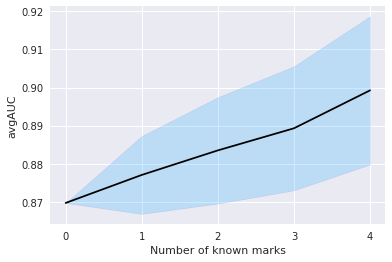

In [97]:
x = values.keys()

y = np.array(list(map(lambda x: np.mean(x[1]), values.items())))
print(y)
error = np.array(list(map(lambda x: np.std(x[1]), values.items())))

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error, edgecolor='#1B2ACC', facecolor='#089FFF',alpha=0.2
    )
plt.xlabel("Number of known marks")
plt.xticks(np.arange(0, 5, step=1))
plt.ylabel("avgAUC")
plt.show()

## Run Shapley Analysis Estimation using MSA

Next, we compute the Shapley values on predicted value functions using the MSA algorithm. The main idea is that we do not need to compute all instances of the value function. Instead, we will only compute a subset of instances and use these to predict the missing value functions. This is useful because in our case, the value function is prediction the model and we have many TFs to predict on.

Running on all 35 factors would require 35 million, so we choose a 19 sized subset that are used in the muticell analysis.

In [5]:
selected_marks = ['CEBPB', 'CHD2', 'CTCF', 'DNase', 'EZH2', 'GABP', 'JunD', 'Max', 'Mxi1', 
                  'NRSF', 'Nrf1', 'Pol2', 'RFX5', 'Rad21', 'TAF1', 'TBP', 'USF2', 'c-Myc', 
                  'p300']


In [6]:
auc_values

,permutation,GABP,Egr-1,NRSF,DNase,CTCF,EZH2,ATF3,p300,Pol2-4H8,...,RXRA,SP1,TCF12,BRCA1,Mxi1,SIN3A,USF2,Znf143,averageAuROC,maskedAverageAuROC
0,[],0.986634,0.990556,0.803433,0.827141,0.919498,0.638163,0.767317,0.626376,0.909048,...,NaN,0.841314,0.908914,NaN,0.903548,0.869706,0.939975,0.923252,0.869723,0.869723
1,['CEBPB'],0.988263,0.991588,0.803079,0.827209,0.919625,0.689345,0.767754,0.602082,0.911296,...,NaN,0.839046,0.910720,NaN,0.904923,0.872113,0.941648,0.923708,0.873099,0.869006
2,['CHD2'],0.989887,0.993368,0.806143,0.831844,0.920562,0.675963,0.994874,0.998937,0.908999,...,NaN,0.938285,0.915090,NaN,0.915247,0.872579,0.941773,0.928435,0.908106,0.905142
3,['CTCF'],0.986759,0.990238,0.802581,0.841542,1.000000,0.629471,0.922418,0.748405,0.909012,...,NaN,0.865323,0.899787,NaN,0.899129,0.875323,0.938303,0.950317,0.885458,0.881763
4,['DNase'],0.987203,0.995095,0.813235,1.000000,0.926894,0.646761,0.782071,0.769572,0.918053,...,NaN,0.915637,0.951361,NaN,0.925728,0.913270,0.948982,0.949239,0.901109,0.897919
5,['EZH2'],0.986548,0.990609,0.803531,0.826895,0.919681,1.000000,0.768067,0.625938,0.909150,...,NaN,0.840732,0.908578,NaN,0.903529,0.870481,0.939779,0.923373,0.881303,0.877474
6,['GABP'],1.000000,0.992148,0.800718,0.827104,0.919656,0.647480,0.762253,0.620935,0.910442,...,NaN,0.844387,0.911581,NaN,0.906154,0.871089,0.942417,0.924783,0.873185,0.869094
7,['JunD'],0.986537,0.990585,0.801945,0.827034,0.919743,0.647793,0.765754,0.594704,0.909097,...,NaN,0.839770,0.910173,NaN,0.903760,0.870644,0.939582,0.923562,0.869152,0.869152
8,['Max'],0.989921,0.992533,0.806170,0.828861,0.920254,0.652639,0.760128,0.590201,0.954509,...,NaN,0.841371,0.910145,NaN,0.919237,0.912971,0.942829,0.926223,0.881304,0.877475
9,['Mxi1'],0.991801,0.991371,0.806757,0.832521,0.919617,0.674212,0.751500,0.558623,0.933133,...,NaN,0.839747,0.909860,NaN,1.000000,0.885049,0.931917,0.924298,0.879785,0.875907


In [7]:
# get singleton marks, which gives us a list of all players
# all 35 marks that are used to evaluate
marks = list(map(lambda x: split_marks(x), auc_values['permutation']))

# all 19 marks that are used in Shapley analysis
singleton_marks = list(filter(lambda x: (len(x) == 1) and (x[0] in selected_marks), marks))
singleton_marks = [item for sublist in singleton_marks  for item in sublist]

# TODO dict is used for ?
singleton_marks_dict = dict((y, x) for x, y in enumerate(singleton_marks))
singleton_marks_dict

{'CEBPB': 0,
 'CHD2': 1,
 'CTCF': 2,
 'DNase': 3,
 'EZH2': 4,
 'GABP': 5,
 'JunD': 6,
 'Max': 7,
 'Mxi1': 8,
 'NRSF': 9,
 'Nrf1': 10,
 'Pol2': 11,
 'RFX5': 12,
 'Rad21': 13,
 'TAF1': 14,
 'TBP': 15,
 'USF2': 16,
 'c-Myc': 17,
 'p300': 18}

In [8]:
# Create all possible orderings of the players
orderedList = [i for i in range(len(selected_marks))]

depth = 4 # len(selected_marks)


# TODO why do you need both?
R_orderings = list(enumerate(shapley.power_set(orderedList)))
# smaller depth to decrease complexity
R_orderings_sampled = list(filter(lambda x: len(x[1]) <= depth, R_orderings))

In [9]:
# define the characteristic function
characteristic_function = np.zeros(len(R_orderings_sampled))

In [10]:
# generate X matrix and y labels for projection pursuit regression
sample_size = 0
projection_train_data=np.zeros((0,len(selected_marks)))
y=[]

# fill each row in the train data
for i, row in auc_values.iterrows():
    index_marks = split_marks(row['permutation'])
    if (set(index_marks).issubset(selected_marks)):
        # make new row
        new_row = np.zeros((1, len(selected_marks)))
        for l in index_marks:
            new_row[0, singleton_marks_dict[l]] = 1
        projection_train_data = np.append(projection_train_data, new_row, axis=0)
        y.append(row['averageAuROC'])
        
        # TODO index to char function
        index = R_ordering_from_marks(index_marks, R_orderings_sampled, selected_marks)[0]
        characteristic_function[index] = row['averageAuROC']
        sample_size += 1
                           
print(f"Using {sample_size} samples")
        
    

Using 2565 samples


In [11]:
# build a matrix that is #random calcs by len(players)  and predict on v
estimator = ProjectionPursuitRegressor()
estimator.fit(projection_train_data, y)

ProjectionPursuitRegressor(backfit_maxiter=10, degree=3, eps_backfit=0.01,
              eps_stage=0.0001, example_weights='uniform',
              fit_type='polyfit', opt_level='high',
              out_dim_weights='inverse-variance', plot_epoch=50, r=10,
              random_state=None, show_plots=False, stage_maxiter=100)

In [12]:
# predict the missing characteristic values
print(f"prediction {len(R_orderings_sampled)-sample_size} predictions...")

predicted = 0

for x in R_orderings_sampled:
    # if we havent computed the characteristic function, compute it
    if (characteristic_function[[x[0]]] == 0):
        prediction_vector = np.zeros(len(singleton_marks))
        prediction_vector[x[1]] = 1
        characteristic_function[x[0]] = estimator.predict(np.matrix(prediction_vector))
        if (predicted % 10000 == 0):
            print(f"\tPredicted {predicted} out of {len(R_orderings_sampled)-sample_size} predictions")
        predicted += 1


prediction 2471 predictions...
	Predicted 0 out of 2471 predictions


In [13]:
# compute the actual Shapley value
importlib.reload(shapley)
value_function = list(map(lambda x: x - characteristic_function[0], characteristic_function))
shapleys = shapley.compute_shapley_values_1d(singleton_marks, characteristic_function, depth=depth)

Computing Shapley for 0
Shapley for [0] is 0.0004185566385924083
Computing Shapley for 1
Shapley for [1] is 0.00696249728884251
Computing Shapley for 2
Shapley for [2] is 0.003084986716004631
Computing Shapley for 3
Shapley for [3] is 0.006172102220765723
Computing Shapley for 4
Shapley for [4] is 0.0022910458836657194
Computing Shapley for 5
Shapley for [5] is 0.0004300915216877347
Computing Shapley for 6
Shapley for [6] is -8.224368496200312e-05
Computing Shapley for 7
Shapley for [7] is 0.0018431732594804422
Computing Shapley for 8
Shapley for [8] is 0.001552716638700671
Computing Shapley for 9
Shapley for [9] is 0.0014303464000463154
Computing Shapley for 10
Shapley for [10] is 0.00022826392995595787
Computing Shapley for 11
Shapley for [11] is 0.0013066167203024683
Computing Shapley for 12
Shapley for [12] is 0.0026317225430225297
Computing Shapley for 13
Shapley for [13] is 0.0006039979356958747
Computing Shapley for 14
Shapley for [14] is 0.0006583099415686175
Computing Shapley 

## Figure for 1D Shapley Analysis


### 1-D Shapley Analysis

DNase, CHD2, and p300 are highest contributors.
- Dnase is expected
- CHD2: chromatin organization modifier
- p300: chromatin remodeling via Histone acetyltransferases 
- CTCF: chromatin architecture
- Rfx5: immune related?

Lowest contributors
- Myc-c: global chromatin structure



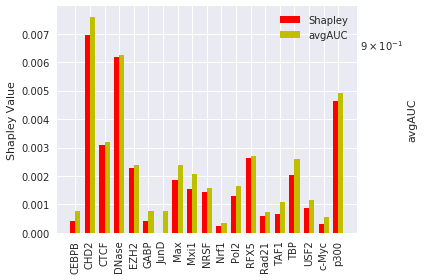

In [14]:
N = len(shapleys)

ind = np.arange(N)  # the x locations for the groups
width = 0.35        # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(ind, shapleys, width, color='r')
ax1.set_ylabel('Shapley Value')
# ax.set_title('Shapley Values and auROC')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(selected_marks, rotation='vertical')
ax1.set_ylim([0,max(shapleys)+.001])

ax2 = ax1.twinx()
masked_auc_single = auc_values['maskedAverageAuROC'][1:20]

rects2 = ax2.bar(ind + width, masked_auc_single, width, color='y')

# add some text for labels, title and axes ticks
ax2.set_ylabel('avgAUC')
ax2.set_yscale('log')
ax2.grid(False)
ax1.legend((rects1[0], rects2[0]), ('Shapley', 'avgAUC'))

fig.tight_layout()
plt.show()

## 2D Shapley Analysis

In [15]:
# compute the actual Shapley value
import importlib
importlib.reload(shapley)
    
value_function = list(map(lambda x: (x - characteristic_function[0])*100, characteristic_function))

shapleys_2d = shapley.compute_shapley_values_2d(singleton_marks, value_function, depth=depth)

Computing 2d Shapley value for ['CEBPB', 'CHD2']
Shapley for [0, 1] is -0.02966970897523321
Shapley for [0] is 0.058767700722824286
Shapley for [0] is 0.058767700722824286
Computing 2d Shapley value for ['CEBPB', 'CTCF']
Shapley for [0, 2] is 0.009523086830686357
Shapley for [0] is 0.058767700722824286
Shapley for [1] is 0.540205568059565
Computing 2d Shapley value for ['CEBPB', 'DNase']
Shapley for [0, 3] is 0.013287856012682338
Shapley for [0] is 0.058767700722824286
Shapley for [2] is 0.3732602084427527
Computing 2d Shapley value for ['CEBPB', 'EZH2']
Shapley for [0, 4] is -0.02275080151284958
Shapley for [0] is 0.058767700722824286
Shapley for [3] is 0.4466532747920321
Computing 2d Shapley value for ['CEBPB', 'GABP']
Shapley for [0, 5] is -0.02655517727742956
Shapley for [0] is 0.058767700722824286
Shapley for [4] is 0.35245935531233336
Computing 2d Shapley value for ['CEBPB', 'JunD']
Shapley for [0, 6] is 0.0036265966228182407
Shapley for [0] is 0.058767700722824286
Shapley for [5

Shapley for [2] is 0.3732602084427527
Shapley for [15] is 0.2100303001492197
Computing 2d Shapley value for ['CTCF', 'c-Myc']
Shapley for [2, 17] is 0.006165473389649375
Shapley for [2] is 0.3732602084427527
Shapley for [16] is 0.15550140732119824
Computing 2d Shapley value for ['CTCF', 'p300']
Shapley for [2, 18] is -0.16020538510679636
Shapley for [2] is 0.3732602084427527
Shapley for [17] is 0.14788193771065716
Computing 2d Shapley value for ['DNase', 'EZH2']
Shapley for [3, 4] is -0.0003931254914774826
Shapley for [3] is 0.4466532747920321
Shapley for [3] is 0.4466532747920321
Computing 2d Shapley value for ['DNase', 'GABP']
Shapley for [3, 5] is 0.0032236748913258627
Shapley for [3] is 0.4466532747920321
Shapley for [4] is 0.35245935531233336
Computing 2d Shapley value for ['DNase', 'JunD']
Shapley for [3, 6] is 0.005518480662088899
Shapley for [3] is 0.4466532747920321
Shapley for [5] is 0.20417698505228088
Computing 2d Shapley value for ['DNase', 'Max']
Shapley for [3, 7] is -0.

Shapley for [6] is 0.14510294070109925
Shapley for [9] is 0.17970698035204757
Computing 2d Shapley value for ['JunD', 'Pol2']
Shapley for [6, 11] is 0.0035656825303024193
Shapley for [6] is 0.14510294070109925
Shapley for [10] is 0.1311493610586829
Computing 2d Shapley value for ['JunD', 'RFX5']
Shapley for [6, 12] is -0.0011182000378161026
Shapley for [6] is 0.14510294070109925
Shapley for [11] is 0.18504875255160155
Computing 2d Shapley value for ['JunD', 'Rad21']
Shapley for [6, 13] is -0.004067099712628777
Shapley for [6] is 0.14510294070109925
Shapley for [12] is 0.19907090868232474
Computing 2d Shapley value for ['JunD', 'TAF1']
Shapley for [6, 14] is 0.0029519749770584177
Shapley for [6] is 0.14510294070109925
Shapley for [13] is 0.1519429469895784
Computing 2d Shapley value for ['JunD', 'TBP']
Shapley for [6, 15] is 0.006673537318569393
Shapley for [6] is 0.14510294070109925
Shapley for [14] is 0.16042476246571769
Computing 2d Shapley value for ['JunD', 'USF2']
Shapley for [6, 

Shapley for [11] is 0.18504875255160155
Shapley for [12] is 0.19907090868232474
Computing 2d Shapley value for ['Pol2', 'TAF1']
Shapley for [11, 14] is -0.061729323333257466
Shapley for [11] is 0.18504875255160155
Shapley for [13] is 0.1519429469895784
Computing 2d Shapley value for ['Pol2', 'TBP']
Shapley for [11, 15] is -0.06049938514531333
Shapley for [11] is 0.18504875255160155
Shapley for [14] is 0.16042476246571769
Computing 2d Shapley value for ['Pol2', 'USF2']
Shapley for [11, 16] is -0.020507559809697398
Shapley for [11] is 0.18504875255160155
Shapley for [15] is 0.2100303001492197
Computing 2d Shapley value for ['Pol2', 'c-Myc']
Shapley for [11, 17] is -0.018682303480959506
Shapley for [11] is 0.18504875255160155
Shapley for [16] is 0.15550140732119824
Computing 2d Shapley value for ['Pol2', 'p300']
Shapley for [11, 18] is 0.05696381697950341
Shapley for [11] is 0.18504875255160155
Shapley for [17] is 0.14788193771065716
Computing 2d Shapley value for ['RFX5', 'Rad21']
Shaple

In [22]:
shapley_matrix


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.96697090e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.52308683e-03,  1.32878560e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
    

## Plot 2-D Shapley Matrix

In [19]:

matrix_data = list(map(lambda x: x[1], shapleys_2d[0]))
shapley_matrix = np.zeros((len(selected_marks), len(selected_marks)))
indices = np.tril_indices(len(selected_marks),-1)
shapley_matrix[indices] = matrix_data    

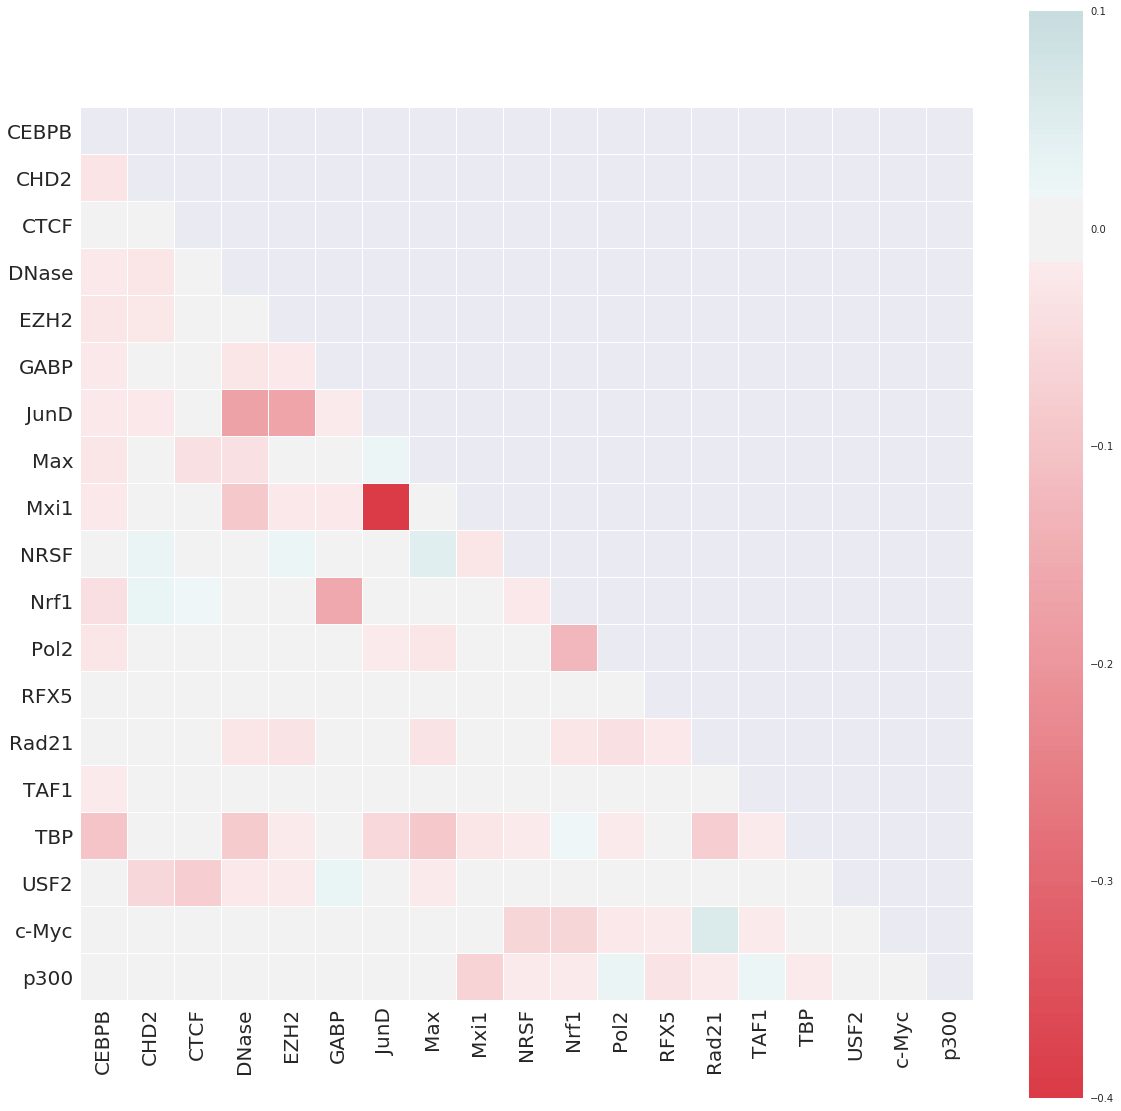

In [40]:

# Generate a mask for the upper triangle
mask = np.zeros_like(shapley_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# ax.set_title("2-D Shapley Analysis", fontsize=20)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 200, as_cmap=True)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(shapley_matrix,mask=mask, yticklabels=selected_marks,xticklabels=selected_marks, cmap=cmap,center=0,
            square=True, linewidths=0.05, vmin=-0.4, vmax=0.1)

## Plotting information from 2D Shapley

In [194]:

matrix_data = list(map(lambda x: x[1], shapleys_2d[1]))
shapley_matrix = np.zeros((len(selected_marks), len(selected_marks)))
indices = np.tril_indices(len(selected_marks),-1)
shapley_matrix[indices] = matrix_data 

ValueError: shape mismatch: value array of shape (171,3) could not be broadcast to indexing result of shape (171,)

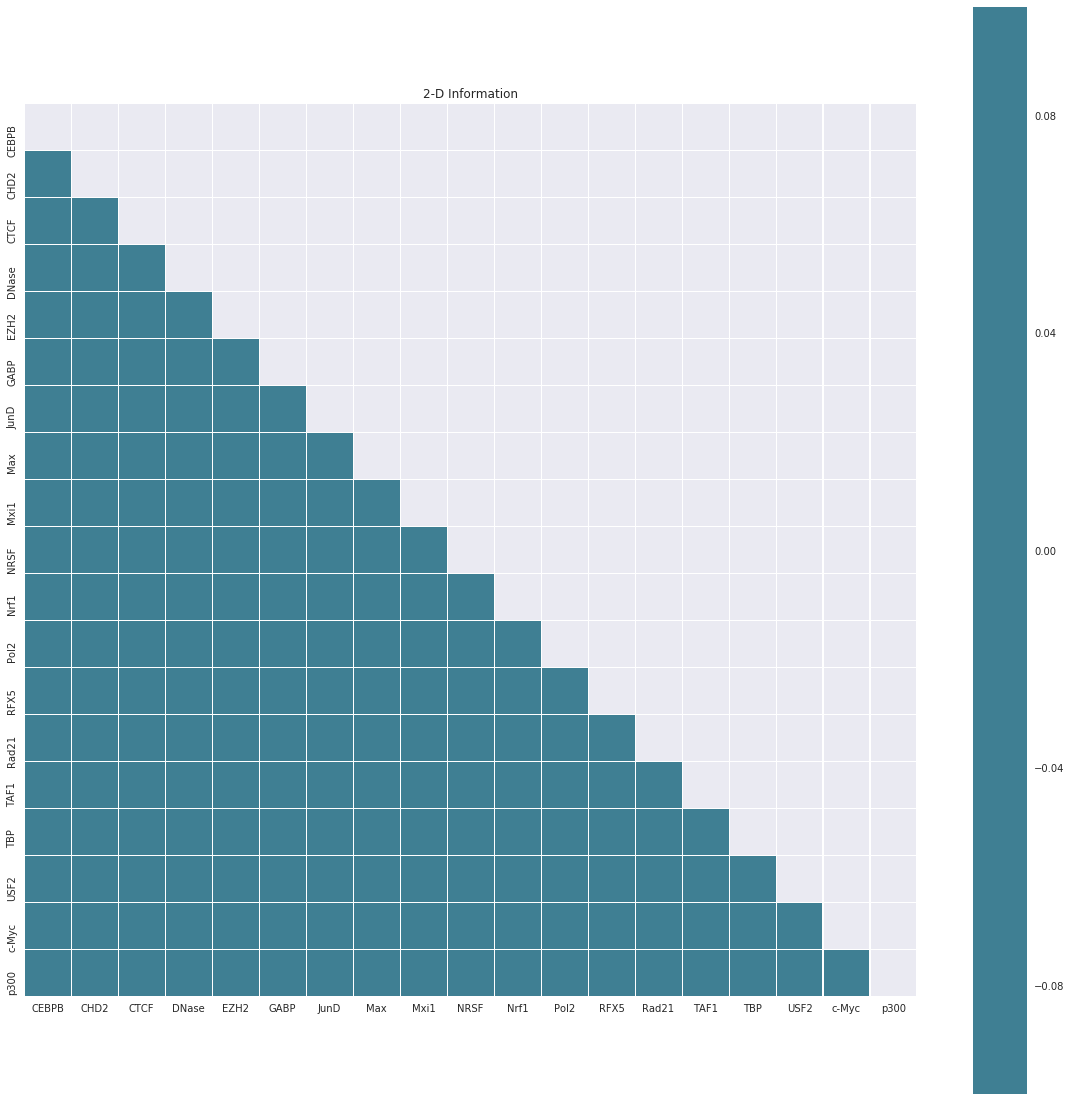

In [195]:
# Generate a mask for the upper triangle
mask = np.zeros_like(shapley_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

ax.set_title("2-D Information")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(shapley_matrix,mask=mask, yticklabels=selected_marks,xticklabels=selected_marks, cmap=cmap,center=0,
            square=True, linewidths=0.05)

In [212]:
for C, n in shapleys_2d[1]:
    i_nj = n[0]-n[1]
    j_ni = n[0]-n[2]
    
    if (n[0]>0):
        print(f"{C}")

['CEBPB', 'CTCF']
['CEBPB', 'DNase']
['CEBPB', 'JunD']
['CEBPB', 'Nrf1']
['CEBPB', 'RFX5']
['CHD2', 'JunD']
['CHD2', 'Pol2']
['CHD2', 'Rad21']
['CHD2', 'TAF1']
['CTCF', 'EZH2']
['CTCF', 'GABP']
['CTCF', 'JunD']
['CTCF', 'Max']
['CTCF', 'Mxi1']
['CTCF', 'Nrf1']
['CTCF', 'Pol2']
['CTCF', 'TAF1']
['CTCF', 'TBP']
['CTCF', 'c-Myc']
['DNase', 'EZH2']
['DNase', 'GABP']
['DNase', 'JunD']
['DNase', 'c-Myc']
['EZH2', 'NRSF']
['EZH2', 'RFX5']
['EZH2', 'Rad21']
['GABP', 'Rad21']
['GABP', 'p300']
['JunD', 'Mxi1']
['JunD', 'Pol2']
['JunD', 'TAF1']
['JunD', 'TBP']
['JunD', 'c-Myc']
['JunD', 'p300']
['Max', 'p300']
['Mxi1', 'p300']
['NRSF', 'RFX5']
['NRSF', 'p300']
['Nrf1', 'USF2']
['Nrf1', 'c-Myc']
['Nrf1', 'p300']
['Pol2', 'Rad21']
['Pol2', 'p300']
['RFX5', 'USF2']
['RFX5', 'p300']
['Rad21', 'USF2']
['Rad21', 'c-Myc']
['Rad21', 'p300']
['TAF1', 'p300']
['TBP', 'p300']
['USF2', 'p300']
['c-Myc', 'p300']
